In [1]:
import sys
sys.path.append(r'C:\Users\hugo.perezdealbeniz\Documents\GitHub\ranking_DIP_european_equities\code_in_production')

In [2]:
import eikon as ek
import pandas as pd
from tqdm import tqdm
import os

import utils

ek.set_app_key('89915a3b58874e1599870c6ecc45d6edd6344f8c')

### Download Function
---

In [3]:
#lista de tickers deseados
constituents_list = pd.read_excel(r'C:\Users\hugo.perezdealbeniz\Desktop\Ranking DIP European Equities\ReutersEikon\data_retrieval_eikon.xlsm',sheet_name='JL_data',skiprows=8)['Unnamed: 7'].dropna().tolist()

In [4]:
len(constituents_list)

1825

In [5]:
#las funciones de eikon a descargar
fields_list = ['TR.TotalDebtToEV',
 #'TR.EV',
 #'TR.EVToSales',
 #'TR.NetDebtToEV',
 #'TR.PriceToSalesPerShare',
 #'TR.EVTOEBIT',
 #'TR.PE',
 #'TR.PriceToCFPerShare',
 #'TR.PriceToBVPerShare',
 #'TR.NetDebtToEBITDA',
 #'TR.TotalDebtToEBITDA',
 #'TR.EVTOEBITDA',
 #'TR.CompanyMarketCapitalization',
 #'TR.EVTOOperatingCashFlow',
 #'TR.PriceToTangBVPerShare',
 #'TR.HistPEG',
 #'TR.DividendYield'
 ]

In [6]:
#parametros de la funcion
parameters = {'SDate':'2000-01-01','EDate':'2023-01-01','Frq':'M','Curn':'EUR'}

In [15]:
#directorio en el que guardar los datos
dir_fp = 'Z:\Interés Departamental\Model Portfolio\Hugo\pruebas eikon ruben'

### Reconstruction
---

- concat all the dfs
- dropna
- drop duplicates
- pivot  
- should check len of individual dfs so faulty ones get get dropped (only if interferes with pivot)
- concated_df['Date'] = concated_df.Date.apply(lambda x: x[:10])
- pivoted_df = concated_df.pivot(index='Date',columns='Instrument',values='Price Close')
- to_csv()

In [7]:
def vertical_download(fields_list,constituents_list,parameters,dir_fp):
    
    os.chdir(fr'{dir_fp}')
    
    for field in fields_list:
        try:
            field_name = field.split('.')[-1]
            os.mkdir(field_name)
            os.mkdir(field_name+'/raw_data')
            fields = [field,field+'.date']
            print(f'Downloading {field_name}')

            fails = []
            dfs_list = []
            
            for instrument in tqdm(constituents_list):
                try:
                    df, err = ek.get_data(instrument, fields, parameters)
                    df.to_csv(f"{field_name}/raw_data/{instrument}.csv")
                    dfs_list.append(df)
                except Exception as x:
                    fails.append(instrument)
                    print(x)
            for instrument in tqdm(fails):
                try:
                    df, err = ek.get_data(instrument, fields, parameters)
                    df.to_csv(f"{field_name}/raw_data/{instrument}.csv")
                    dfs_list.append(df)
                except Exception as x:
                    print(f'Failed twice for {instrument}',x)

            concated_df = pd.concat(dfs_list)
            processed_df = concated_df.dropna().drop_duplicates()
            processed_df['Date'] = processed_df.Date.apply(lambda x: x[:10])
            pivoted_df = processed_df.pivot(index='Date',columns='Instrument',values=list(set(processed_df.columns)-set(['Date','Instrument']))[0])
            days_list = utils.create_dates_list('days',as_str=True)
            months_list = utils.create_dates_list('months',as_str=True)
            dates_dict = {}
            for i in days_list:
                dates_dict[i] = pd.NA
            dates_dict.update(pivoted_df.T.to_dict())
            complete_dates_df = pd.DataFrame(dates_dict).T.sort_index()
            filled_df = complete_dates_df.fillna(method='ffill',limit=7).loc[months_list]
            filled_df.to_csv(f'{field_name}/{field_name}.csv')
        except Exception as x:
            print(x)

In [14]:
#import time
#time.sleep(32272)

vertical_download(fields_list,constituents_list[:3],parameters)

100%|██████████| 3/3 [00:03<00:00,  1.03s/it]
0it [00:00, ?it/s]


TotalDebtToEV


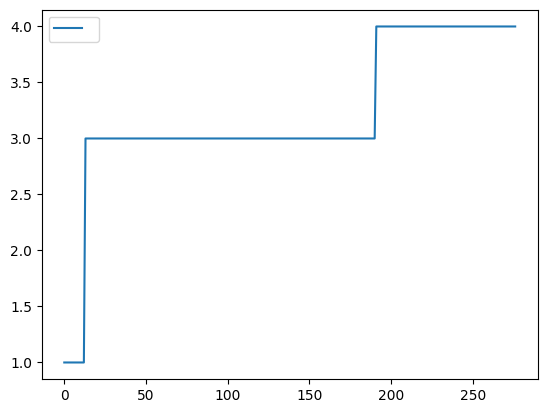

In [17]:
for index,i in enumerate(os.listdir(dir_fp)):
    if index > 20:# or i=='PriceToTangBVPerShare':
        continue
    print(i)
    df = pd.read_csv(dir_fp+f'/{i}/{i}.csv')
    df.notna().sum(axis=1).plot(legend=True)